In [2]:
# %pip install gymnasium matplotlib numpy pandas seaborn stable-baselines3[extra] ale-py gym-anytrading tqdm scipy scikit-learn dask-ml

In [3]:
import os
import random
import shutil
import heapq
import pickle
import psutil

import numpy as np

import modin.pandas as pd
import modin.config as cfg


import matplotlib.pyplot as plt
import torch
from torch import nn
from scipy.spatial import KDTree
import ta
import kagglehub

import gymnasium as gym
from gymnasium import spaces
import gym_anytrading

from stable_baselines3 import DQN, PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.buffers import BaseBuffer
from stable_baselines3.common.type_aliases import ReplayBufferSamples
from stable_baselines3.common.buffers import ReplayBuffer

from typing import Union, Any, Optional

# from sklearn.preprocessing import MinMaxScaler
import dask.array as da
from dask_ml.preprocessing import MinMaxScaler


from signal import Signals
import time
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import stumpy
from numba import cuda
import IPython.display
import gc

## PREPROCESSING

### Get data and add technical features

In [4]:
import os, shutil
from modin.config import Engine

Engine.put("dask")  # Modin on Dask

import kagglehub, pandas as pd, dask.dataframe as dd
from dask.distributed import Client, progress
import ta, pyarrow as pa

print(pa.__version__)  # should be ≥ 10.0.1

client = Client()
print(client)


def add_ta(df: pd.DataFrame) -> pd.DataFrame:
    return ta.add_all_ta_features(
        df,
        open="open",
        high="high",
        low="low",
        close="close",
        volume="volume",
        fillna=True,
    )


path_sp500 = kagglehub.dataset_download(
    "gratefuldata/intraday-stock-data-1-min-sp-500-200821"
)
files_sp500 = os.listdir(path_sp500)
print("Files:", files_sp500)

output_path = "datasets/sp500_ta"

local_dir = "./datasets/sp500"
os.makedirs(local_dir, exist_ok=True)
for f in files_sp500:
    shutil.copy2(os.path.join(path_sp500, f), os.path.join(local_dir, f))
print("Files saved to", local_dir)

if os.path.exists(output_path):
    print("Dataset already exists.")
    ddf = dd.read_parquet(output_path)
else:
    print("Making dataset.")
    MAX_LOOKBACK = 256  # longest rolling window length
    # set index to datetime
    ddf = dd.read_csv(
        os.path.join(local_dir, "*.csv"),
        blocksize="64 MB",
        assume_missing=True,
        parse_dates={"datetime": ["date"]},
    ).set_index(
        "datetime",
        sorted=False,
        # drop=False
    )  # needed for map_overlap

    sample = ddf.head(MAX_LOOKBACK)  # small pandas DF (triggers 1 read)
    # make sure index is a column
    # if sample.index.name == "datetime":
    #     sample = sample.reset_index()
    meta = add_ta(sample).iloc[0:0]  # keep cols, drop rows

    ddf = ddf.map_overlap(
        add_ta,
        before=MAX_LOOKBACK - 1,
        after=0,
        meta=meta,
    )
    ddf = ddf.persist()
    progress(ddf)

    ddf.to_parquet(output_path, write_index=True)
    # ddf.to_csv("datasets/sp500_ta.csv", single_file=True, index=True)

    print("Finished TA feature generation with full look‑back safety.")
print("DataFrame columns:", ddf.columns.tolist())
ddf_fresh = ddf

19.0.1
<Client: 'tcp://127.0.0.1:60570' processes=8 threads=32, memory=93.71 GiB>
Files: ['1_min_SPY_2008-2021.csv']
Files saved to ./datasets/sp500
Dataset already exists.
DataFrame columns: ['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'barCount', 'average', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend

In [5]:
ddf = ddf_fresh

### Normalize volume

In [6]:
from dask_ml.preprocessing import MinMaxScaler

# 1. Identify the volume columns
volume_features = ["volume", "volume_obv", "volume_vwap"]

# 2. Build a boolean mask of rows where ALL volume_features are non‑null
mask = ddf[volume_features].notnull().all(axis=1)

# 3. Fit the scaler on the valid subset
scaler = MinMaxScaler()
scaler.fit(ddf[volume_features][mask])

# 4. Transform the entire column block (rows with any NaN stay NaN after transform)
scaled = scaler.transform(ddf[volume_features])

# 5. Drop the originals and overwrite with the scaled columns
ddf_scaled = ddf.drop(columns=volume_features)
# `scaled` has the same column names as volume_features by default:
ddf_scaled = ddf_scaled.assign(**{col: scaled[col] for col in volume_features})


# Compute each stat in parallel, then collect to pandas
mins = ddf_scaled[volume_features].min().compute()
means = ddf_scaled[volume_features].mean().compute()
maxs = ddf_scaled[volume_features].max().compute()

# Print them out
print("Scaled volume feature stats:")
for col in volume_features:
    print(f"{col:12s}  min={mins[col]:.4f}  mean={means[col]:.4f}  max={maxs[col]:.4f}")

# print(ddf_scaled.columns)

Scaled volume feature stats:
volume        min=0.0000  mean=0.0082  max=1.0000
volume_obv    min=0.0000  mean=0.4125  max=1.0000
volume_vwap   min=0.0000  mean=0.4019  max=1.0000


### Regular trading hours

In [7]:
# Extract hour and minute from the index for filtering
ddf["hour"] = ddf.index.hour
ddf["minute"] = ddf.index.minute

# 2. Filter for Regular Trading Hours (RTH)
rth_filter = (
    ((ddf["hour"] == 9) & (ddf["minute"] >= 30))
    | ((ddf["hour"] > 9) & (ddf["hour"] < 16))
    | ((ddf["hour"] == 16) & (ddf["minute"] == 0))
)
ddf = ddf.loc[rth_filter]

# 3. Reset index, but keep datetime as a column for feature access
ddf = ddf.reset_index()  # Now 'datetime' is a column
print(ddf.columns)

ddf_preprocessed = ddf

Index(['datetime', 'Unnamed: 0', 'open', 'high', 'low', 'close', 'volume',
       'barCount', 'average', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_d

#### RUN THIS CELL TO RESTORE DDF

In [8]:
# Restore ddf
ddf = ddf_preprocessed
print(ddf.columns)

Index(['datetime', 'Unnamed: 0', 'open', 'high', 'low', 'close', 'volume',
       'barCount', 'average', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_d

### Filter dataset

In [9]:
reduce_dataset = True

if reduce_dataset:
    # define your cut‑off dates
    start, end = "2016-01-01", "2021-01-01"

    # boolean mask on the datetime column
    ddf = ddf[(ddf["datetime"] >= start) & (ddf["datetime"] < end)]

    # 1) get the year and date Series
    years = ddf["datetime"].dt.year
    dates = ddf["datetime"].dt.date

    # 2) find all unique years (small list)
    unique_years = years.unique().compute()

    # 3) for each year, filter & collect unique dates
    dates_per_year = {}
    for y in unique_years:
        mask = years == y
        #  .unique() on the filtered date‐series
        dates_per_year[y] = dates[mask].unique().compute()

    # 4) print
    for year, ds in sorted(dates_per_year.items()):
        print(year, ds)
start = ddf["datetime"].min().compute()
end = ddf["datetime"].max().compute()
print(f"Date range: {start} → {end}")

# 5. Select features and drop NaNs
feature_cols = [
    "datetime",
    "close",
    "trend_sma_fast",
    "trend_sma_slow",
    "trend_macd_diff",
    "trend_adx",
    "momentum_rsi",
    "momentum_ao",
    "volatility_atr",
    "volatility_bbw",
    "volatility_dcw",
    "volume_obv",
    "volume_vwap",
]

ddf = ddf[feature_cols].dropna()
print("DataFrame columns:", ddf.columns.tolist())
print(ddf.head())
print(len(ddf))

2025-04-21 21:56:15,087 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 62a8520bc0c9e42d4861e93d02781d4e initialized by task ('shuffle-transfer-62a8520bc0c9e42d4861e93d02781d4e', 2) executed on worker tcp://127.0.0.1:60613
2025-04-21 21:56:17,252 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 62a8520bc0c9e42d4861e93d02781d4e deactivated due to stimulus 'task-finished-1745286977.251236'
2025-04-21 21:56:17,409 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 938e60bcb36e1a552787ea7641f463c9 initialized by task ('shuffle-transfer-938e60bcb36e1a552787ea7641f463c9', 2) executed on worker tcp://127.0.0.1:60613
2025-04-21 21:56:19,517 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 938e60bcb36e1a552787ea7641f463c9 deactivated due to stimulus 'task-finished-1745286979.5167317'
2025-04-21 21:56:19,737 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b3cb788d69580bccfd49b484431a03d2 initialized by task ('shuffle-transfer-b3cb788d69580bc

2016 0     2016-01-13
1     2016-01-19
2     2016-01-29
3     2016-02-01
4     2016-02-03
         ...    
81    2016-12-09
82    2016-12-13
83    2016-12-14
84    2016-12-16
85    2016-12-27
Name: datetime, Length: 252, dtype: object
2017 0     2017-01-03
1     2017-01-09
2     2017-01-18
3     2017-01-24
4     2017-01-27
         ...    
84    2017-12-21
85    2017-12-22
86    2017-12-26
87    2017-12-27
88    2017-12-28
Name: datetime, Length: 251, dtype: object
2018 0     2018-01-03
1     2018-01-08
2     2018-01-09
3     2018-01-10
4     2018-01-11
         ...    
81    2018-11-30
82    2018-12-04
83    2018-12-12
84    2018-12-20
85    2018-12-26
Name: datetime, Length: 251, dtype: object
2019 0     2019-01-07
1     2019-01-08
2     2019-01-09
3     2019-01-10
4     2019-01-11
         ...    
80    2019-11-27
81    2019-11-29
82    2019-12-16
83    2019-12-27
84    2019-12-31
Name: datetime, Length: 252, dtype: object
2020 0     2020-01-03
1     2020-01-08
2     2020-01-09
3   

## Change point detection
Change to pandas dataframe

In [10]:
# Dask version
# ddf["log_return"] = ddf["close"].map_partitions(np.log).diff().fillna(0)
# signal = (
#     ddf["log_return"]
#     .to_dask_array(lengths=True)  # Dask Array
#     .compute()  # NumPy Array
#     .reshape(-1, 1)
# )

# Also pandas version
ddf = ddf.repartition(partition_size="100MB")
df = ddf.compute()
df = df.sort_values("datetime")
df["log_return"] = np.log(df["close"]).diff().fillna(0)
signal = df["log_return"].values.reshape(-1, 1)

Compute trend_id

LATEST!!!


[MP] done in 5.07s
[FLUSS] 31 segments in 1.19s


  0%|          | 0/32 [00:00<?, ?it/s]

[FEAT] done in 0.01s
[KMEANS] 5 clusters in 0.24s
[0 1 2 0 0 0 3 0 4 0 0 4 0 0 0 4 0 0 4 0 4 0 0 0 4 0 0 0 4 0 0 4]


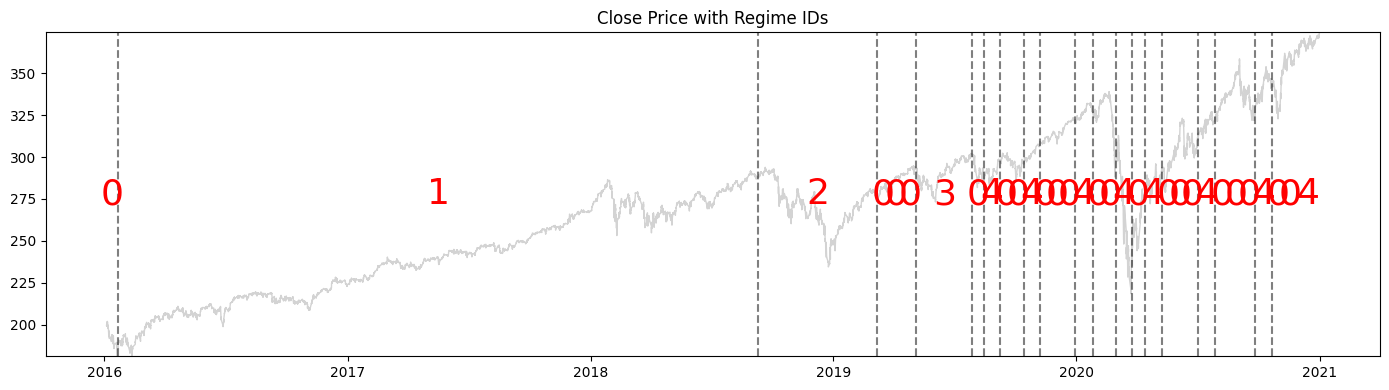

[Timestamp('2016-01-21 23:00:00'), Timestamp('2018-09-09 22:00:00'), Timestamp('2019-03-08 05:00:00'), Timestamp('2019-03-25 20:00:00'), Timestamp('2019-04-15 23:00:00'), Timestamp('2019-05-05 23:00:00'), Timestamp('2019-07-28 20:00:00'), Timestamp('2019-08-15 11:00:00'), Timestamp('2019-09-07 22:00:00'), Timestamp('2019-09-27 10:00:00'), Timestamp('2019-10-15 00:00:00'), Timestamp('2019-11-07 02:00:00'), Timestamp('2019-11-24 17:00:00'), Timestamp('2019-12-12 08:00:00'), Timestamp('2019-12-29 23:00:00'), Timestamp('2020-01-25 17:00:00'), Timestamp('2020-02-12 08:00:00'), Timestamp('2020-02-29 23:00:00'), Timestamp('2020-03-25 13:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-05-08 16:00:00'), Timestamp('2020-05-27 00:00:00'), Timestamp('2020-06-13 14:00:00'), Timestamp('2020-07-02 13:00:00'), Timestamp('2020-07-28 12:00:00'), Timestamp('2020-08-17 22:00:00'), Timestamp('2020-09-07 20:00:00'), Timestamp('2020-09-25 10:00:00'), Timestamp('2020-10-21 12:00:00'), Timestamp('20

In [11]:
import importlib
import final_project_utils

importlib.reload(final_project_utils)
from final_project_utils import *

print_version()

break_times = add_trend_id(df, n_regimes=32, window_size=13 * 5 * 6.5, n_clusters=5)
print(df["trend_id"].unique())

In [12]:
def save_break_points(bp_file, new_bps):
    # load existing as a set, or start empty
    if os.path.exists(bp_file):
        with open(bp_file, "rb") as f:
            break_points = set(pickle.load(f))
    else:
        break_points = set()

    # add new ones
    break_points |= set(new_bps)

    # overwrite back to disk
    with open(bp_file, "wb") as f:
        pickle.dump(break_points, f)


bp_file = "break_points.pkl"
save_break_points(bp_file, break_times)

Plot changepoints

# IMPLEMENTATION

In [13]:
import importlib
import final_project_utils

importlib.reload(final_project_utils)
from final_project_utils import *

print_version()

LATEST!!!


# EXPERIMENTATION

In [14]:
base_config = {
    # TRAINING PARAMETERS
    "log_dir": "./train_logs/base",
    "n_envs": 4,  # number of parallel environments to use for training
    "checkpoint": None,  # path to a checkpoint to load from
    "checkpoint_freq": 5000,  # save a model checkpoint every _ steps
    "eval_freq": 5000,  # evaluate the model every _ steps
    "n_eval_episodes": 10,  # number of episodes to evaluate the model on
    "n_train_timesteps": int(1e6),  # total number of training steps
    "verbose_training": True,
    # RL PARAMETERS (all set to defaults right now, except for seed)
    "policy_args": {
        "net_arch": [64, 64],
        "activation_fn": nn.ReLU,
    },
    "algo_kwargs": {
        "learning_rate": 1e-4,
        "buffer_size": int(1e6),
        "learning_starts": 100,  # how many steps of the model to collect transitions for before learning starts
        "batch_size": 32,
        "tau": 1.0,  # the soft update coefficient ("Polyak update", between 0 and 1) default 1 for hard update
        "gamma": 0.99,
        "train_freq": (4, "step"),  # Update the model every ``train_freq`` steps.
        "gradient_steps": 1,  # How many gradient steps to do after each rollout
        "target_update_interval": int(
            1e4
        ),  # update the target network every ``target_update_interval`` environment steps.
        # DQN only
        # "exploration_fraction": 0.1,  # fraction of entire training period over which the exploration rate is reduced
        # "exploration_initial_eps": 1.0,  # initial value of random action probability
        # "exploration_final_eps": 0.05,  # final value of random action probability
        "seed": 42,
    },
}

fifo_config = base_config.copy()
fifo_config["log_dir"] = "./train_logs/fifo"
fifo_config["algo_kwargs"]["replay_buffer_class"] = ReplayBuffer
# fifo_config["algo_kwargs"]["device"] = "cuda" if torch.cuda.is_available() else "cpu"

df_features = df.drop(columns=["datetime"])
# stock_data = {"SPY": df_features}
stock_data = df_features


def make_env():
    return StockTradingEnv(stock_data)


def make_eval_env():
    return StockTradingEnv(stock_data)  # could be different data if desired


print(f"Number of ticks in SPY data: {len(df_features)}")

Number of ticks in SPY data: 523239


In [19]:
import importlib
import final_project_utils

importlib.reload(final_project_utils)
from final_project_utils import *

print_version()

# Cleanup
IPython.display.clear_output(wait=True)
gc.collect()

env = DummyVecEnv([make_env])
obs = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

# Create a simple SAC model
log_dir = "./train_logs/simple_sac"
os.makedirs(log_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SAC(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=int(1e6),
    batch_size=256,
    replay_buffer_class=ReplayBuffer,
    verbose=1,
    tensorboard_log=log_dir,
    device=device,
)

# model = DQN(
#     "MlpPolicy",
#     env,
#     learning_rate=1e-3,
#     buffer_size=int(1e6),
#     batch_size=256,
#     replay_buffer_class=ReplayBuffer,
#     verbose=1,
#     tensorboard_log=log_dir,
#     device=device,
# )

# Train for a small number of steps\r
try:
    print("\nStarting simple training...")
    def policy_l2(model):
        return sum((p.data**2).sum().item() for p in model.policy.parameters())**0.5
    print("L2 before:", policy_l2(model))
    model.learn(total_timesteps=2000, progress_bar=True)
    print("L2 after :", policy_l2(model))
    print("Training completed successfully!")
except Exception as e:
    print(f"Training failed with error: {e}")
    print(f"Policy network input shape: {model.policy.observation_space.shape}")
    print(f"Environment observation shape example: {obs.shape}")
    try:
        print("\nPolicy architecture:")
        print(model.policy)
    except:
        print("Could not print policy architecture")
    IPython.display.clear_output(wait=True)

Observation shape: (1, 19)
Observation space: Box(-inf, inf, (19,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)
Using device: cuda
Using cuda device

Starting simple training...
L2 before: 29.585110566093658
Logging to ./train_logs/simple_sac\SAC_16


Output()

L2 after : 30.83452393652723
Training completed successfully!


In [ ]:
reset_out = env.reset()  # ← Gymnasium may give (obs, info); SB3 VecEnv gives obs
print("Got:", reset_out)  # see whether it’s a tuple
print("Is tuple?", isinstance(reset_out, tuple))

Got: [[1.9913000e+02 1.9899667e+02 1.9890538e+02 4.2707819e-02 1.7579311e+01
  5.5665184e+01 1.4279412e-01 1.4706543e-01 2.2915116e-01 2.9654649e-01
  1.4393072e+08 1.9901184e+02 0.0000000e+00 0.0000000e+00 1.0000000e+06
  0.0000000e+00 1.0000000e+06 1.0000000e+06 0.0000000e+00]]
Is tuple? False



Testing model...

Performance Summary:
Initial Net Worth: $995000.10
Final Net Worth: $997374.58
Profit/Loss: $2374.48 (0.24%)


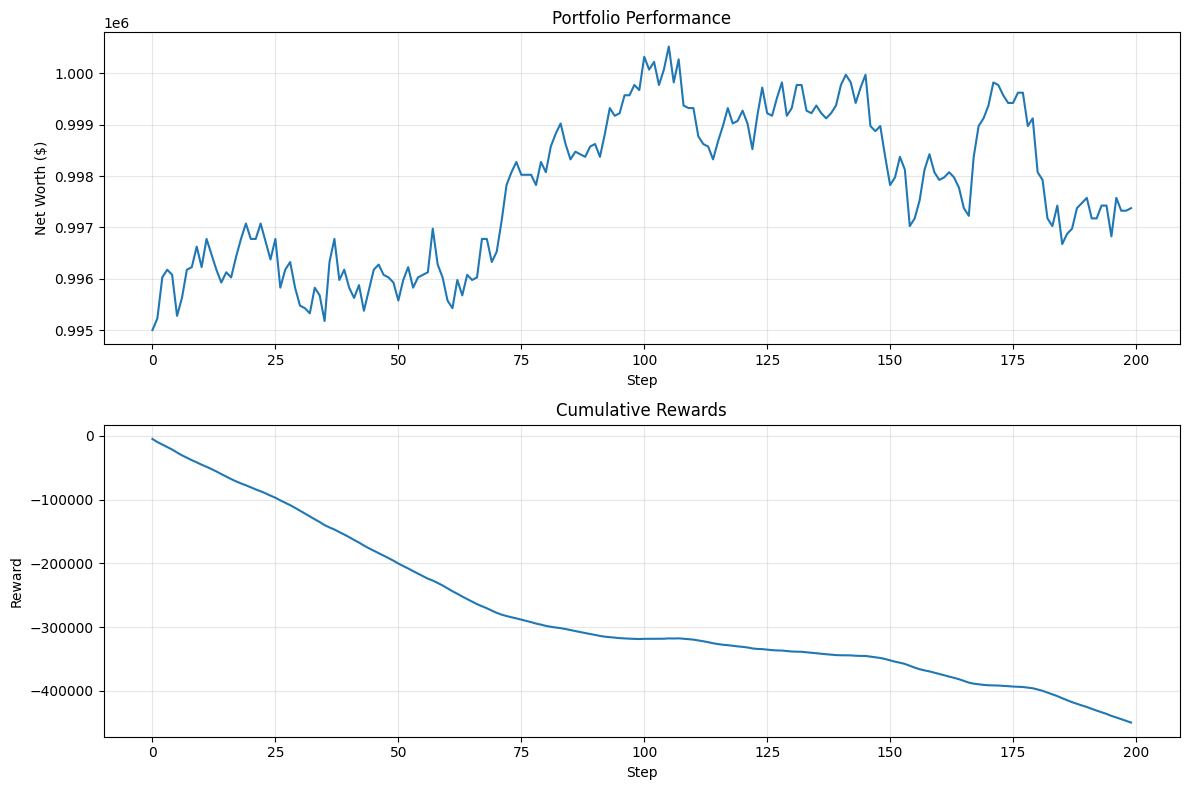

In [20]:
# import importlib
# import final_project_utils

# importlib.reload(final_project_utils)
# from final_project_utils import *

# print_version()

# After training your model
print("\nTesting model...")
test_results = test_model(env, model, n_tests=200)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Portfolio value over time
plt.subplot(2, 1, 1)
plt.plot(test_results["steps"], test_results["net_worths"])
plt.title("Portfolio Performance")
plt.xlabel("Step")
plt.ylabel("Net Worth ($)")
plt.grid(True, alpha=0.3)

# Cumulative rewards
plt.subplot(2, 1, 2)
plt.plot(test_results["steps"], test_results["cumulative_rewards"])
plt.title("Cumulative Rewards")
plt.xlabel("Step")
plt.ylabel("Reward")

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Basic imports
import numpy as np
import os
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import time
from final_project_utils import SERReplayBuffer  # Import custom replay buffer

# Clear any previous outputs

IPython.display.clear_output(wait=True)

# Force garbage collection

gc.collect()

env = DummyVecEnv([make_env])
obs = env.reset()
obs = (
    obs.squeeze()
)  # This removes the batch dimension, making it (19,) instead of (1, 19)

print(f"Observation shape: {obs.shape}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

# Create a simple SAC model with SER
log_dir = "./train_logs/ser_simple"
os.makedirs(log_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# SER configuration
strategy = "surprise"  # Options: "reward", "distribution", "surprise", "coverage"
priority_queue_size = 5000
priority_queue_percent = 0.5

# Create the model with custom replay buffer
model = SAC(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=10000,
    batch_size=256,
    verbose=1,
    tensorboard_log=log_dir,
    device=device,
    replay_buffer_class=SERReplayBuffer,
    replay_buffer_kwargs={
        "strategy": strategy,
        "priority_queue_size": priority_queue_size,
        "priority_queue_percent": priority_queue_percent,
    },
)

# Set Q-networks for SERReplayBuffer
if isinstance(model.replay_buffer, SERReplayBuffer):
    print("Setting Q-networks for SERReplayBuffer...")
    model.replay_buffer.set_q_nets(model.critic.qf0, model.critic_target.qf0)

# Train for a small number of steps
try:
    print("\nStarting simple training with SER...")
    model.learn(total_timesteps=5000, progress_bar=True)
    print("Training completed successfully!")
except KeyboardInterrupt:
    print("\nTraining interrupted by user! Saving current model...")
    interrupted_save_path = os.path.join(
        log_dir, f"interrupted_model_{int(time.time())}"
    )
    model.save(interrupted_save_path)
    print(f"Model saved to {interrupted_save_path}")

    # Force the progress bar to close
    IPython.display.clear_output(wait=True)
    print("Progress bar cleaned up after interruption.")

except Exception as e:
    print(f"Training failed with error: {e}")

    # Print more diagnostic information
    print("\nDiagnostic information:")
    print(f"Policy network input shape: {model.policy.observation_space.shape}")
    print(f"Environment observation shape example: {obs.shape}")

    # Try to print the policy architecture
    try:
        print("\nPolicy architecture:")
        print(model.policy)
    except:
        print("Could not print policy architecture")
finally:
    # This will always run, ensuring cleanup
    env.close()
    print("Environment closed.")

Observation shape: (19,)
Observation space: Box(-inf, inf, (19,), float32)
Action space: Box(-1.0, 1.0, (1,), float32)
Using device: cuda
Using cuda device
Setting Q-networks for SERReplayBuffer...

Starting simple training with SER...
Logging to ./train_logs/ser_simple\SAC_2


Output()

Training failed with error: mat1 and mat2 shapes cannot be multiplied (1x19 and 20x256)

Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic information:
Diagnostic infor

RecursionError: maximum recursion depth exceeded

### FIFO only

In [ ]:
print("cuda" if torch.cuda.is_available() else "cpu")
try:
    train(make_env, make_eval_env, fifo_config)
except Exception as e:
    print(f"Error during training: {e}")

In [ ]:
plot_evaluations(fifo_config["log_dir"])

### SER

In [19]:
env = DummyVecEnv([make_env])
print(f"Observation space: {env.observation_space}")
print(f"Shape: {env.observation_space.shape}")

# Also check what's actually coming from the environment
obs = env.reset()
print(f"Actual observation shape: {obs.shape}")

Observation space: Box(-inf, inf, (19,), float32)
Shape: (19,)
Actual observation shape: (1, 19)


In [20]:
ser_config = base_config.copy()
ser_config["log_dir"] = "./train_logs/ser"
ser_config["algo_kwargs"]["replay_buffer_class"] = SERReplayBuffer

ser_config["strategy"] = "surprise"
ser_config["priority_queue_size"] = 5000
ser_config["priority_queue_percent"] = 0.5


ser_config["algo_kwargs"]["replay_buffer_kwargs"] = {
    "strategy": ser_config["strategy"],
    "priority_queue_size": ser_config["priority_queue_size"],
    "priority_queue_percent": ser_config["priority_queue_percent"],
}

import IPython.display

IPython.display.clear_output(wait=True)

# Also try to force garbage collection
import gc

gc.collect()

train(make_env, make_eval_env, ser_config)

Initializing...
Algorithm kwargs:
  learning_rate: 0.0001
  buffer_size: 1000000
  learning_starts: 100
  batch_size: 32
  tau: 1.0
  gamma: 0.99
  train_freq: (4, 'step')
  gradient_steps: 1
  target_update_interval: 10000
  seed: 42
  replay_buffer_class: <class 'final_project_utils.SERReplayBuffer'>
  replay_buffer_kwargs: {'strategy': 'surprise', 'priority_queue_size': 5000, 'priority_queue_percent': 0.5}


Output()

Training finished or interrupted.

Training...


Evaluations: min: 0.0, max: 0.0, std: 0.0


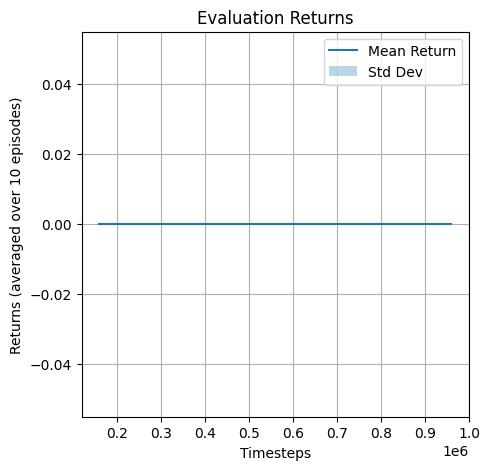

In [ ]:
plot_evaluations(ser_config["log_dir"])